In [1]:
import numpy as np
import pImpactR as impact
import matplotlib.pyplot as plt
int = np.vectorize(int)
cmap = plt.get_cmap('rainbow')

In [2]:
NL_L = 1.8
NL_c = 0.01
NL_t = 0.4
NL_nu= 0.3034496449165134

npt_Test = 3834

In [3]:
beam, lattice = impact.readInputFile('test_IOTA.in')
ke   = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

betx = NL_L/np.sin(2.0*np.pi*NL_nu)
alfx = np.tan(np.pi*NL_nu)

reading ImpactZ input file (test_IOTA.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
print(betx,alfx)

1.9065054393933862 1.4082261727304293


In [5]:
def normalize(data,sign=1):
    data[:,1] = (data[:,0]*sign*alfx/np.sqrt(betx) + data[:,1]*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*sign*alfx/np.sqrt(betx) + data[:,3]*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    
def unnormalize(data,sign=1):
    data[:,1] = (-data[:,0]*sign*alfx + data[:,1])*NL_c/np.sqrt(betx)
    data[:,3] = (-data[:,2]*sign*alfx + data[:,3])*NL_c/np.sqrt(betx)
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c

In [6]:
pData = impact.readParticleData(111110,ke,mass,freq,format_id=2)
normalize(pData)

In [7]:
import scipy
dist = scipy.stats.gaussian_kde(pData[npt_Test:,[0,2]].transpose())
weight = dist([pData[:npt_Test,0],pData[:npt_Test,2]])

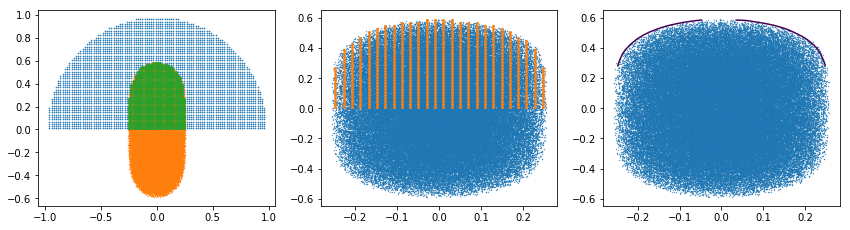

In [8]:
iCore = np.argwhere(weight > 0.2) # empirically found ...
iCore = pData[:npt_Test,-1][iCore]
iCoreTmp = np.in1d(pData[:npt_Test,-1],iCore)
xTmp = pData[:npt_Test,0][iCoreTmp]
yTmp = pData[:npt_Test,2][iCoreTmp]

grid = impact.data.dictClass()
grid.extent = [xTmp.min(),xTmp.max(),yTmp.min(),yTmp.max()]
grid.x, grid.y = np.mgrid[xTmp.min():xTmp.max():64j, yTmp.min():yTmp.max():64j]
grid.points = np.vstack([grid.x.ravel(), grid.y.ravel()])
grid.z = np.reshape(dist(grid.points).T, grid.x.shape)

plt.figure(figsize=(12,3.3))
plt.subplot(1,3,1)
plt.scatter(pData[:npt_Test,0],pData[:npt_Test,2],s=0.4)
plt.scatter(pData[npt_Test::10,0],pData[npt_Test::10,2],s=0.1)
plt.scatter(xTmp,yTmp,s=4.0)
plt.subplot(1,3,2)
plt.scatter(pData[npt_Test::10,0],pData[npt_Test::10,2],s=0.1)
plt.scatter(xTmp,yTmp,s=4.0)
plt.subplot(1,3,3)
plt.scatter(pData[npt_Test::10,0],pData[npt_Test::10,2],s=0.1)
plt.contour(grid.z.T, extent=grid.extent, levels=[0.2]);
plt.tight_layout()

dist = None
weight = None

In [10]:
pData1 = impact.readParticleData(2049,ke,mass,freq,format_id=2)[:npt_Test,:]
index1 = np.argmin(np.abs(pData1[:,-1]-npt_Test))
pData1 = pData1[:index1,:]
print(pData1.shape)
normalize(pData1,-1)

(3067, 9)


In [11]:
pData2 = impact.readParticleData(2050,ke,mass,freq,format_id=2)[:npt_Test,:]
index2 = np.argmin(np.abs(pData2[:,-1]-npt_Test))
pData2 = pData2[:index2,:]
print(pData2.shape)
normalize(pData2)

(3067, 9)


In [12]:
pData = impact.readParticleData(111110,ke,mass,freq,format_id=2)
index = np.argwhere(pData[:,-1]<=npt_Test)
pData = pData[index[:,0],:]
print(pData.shape)
normalize(pData)

(3834, 9)


In [13]:
X1 = pData1[:,0]-1j*pData1[:,1]
X2 = pData2[:,0]-1j*pData2[:,1]
Px = (np.angle(X2)-np.angle(X1))/np.pi/2.0
for i in range(index1):
    if Px[i]<-0.5:
        Px[i]=Px[i]+1.0
    if Px[i]>0.5:
        Px[i]=Px[i]-1.0
        
Y1 = pData1[:,2]-1j*pData1[:,3]
Y2 = pData2[:,2]-1j*pData2[:,3]
Py = (np.angle(Y2)-np.angle(Y1))/np.pi/2.0
for i in range(index1):
    if Py[i]<-0.5:
        Py[i]=Py[i]+1.0
    if Py[i]>0.5:
        Py[i]=Py[i]-1.0
        
P = np.sqrt(Px**2 + Py**2)

In [14]:
index = np.in1d(pData[:npt_Test,-1],pData2[:,-1])
pData=pData[index,:]

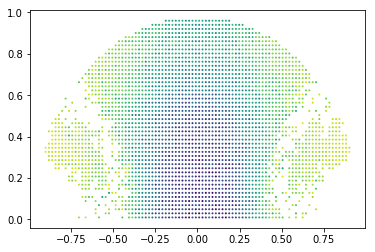

In [15]:
plt.scatter(pData[:,0],pData[:,2],s=1.0,c=P)
plt.scatter(pData[:,0],-pData[:,2],s=1.0,c=P)

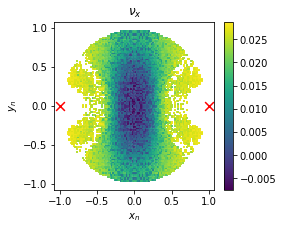

In [27]:
plt.figure(figsize=[4,3.3])
f1=plt.scatter(pData[:,0],pData[:,2],c=Px,s=1.6,marker='s')
plt.scatter(pData[:,0],-pData[:,2],c=Px,s=1.6,marker='s')
plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
plt.xlim(-0.98*1.1,0.98*1.1)
plt.ylim(-0.98*1.1,0.98*1.1)
plt.title(r'$\nu_x$')
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('Realistic.nux_over_arc.at_turn=2049.png',dpi=180)

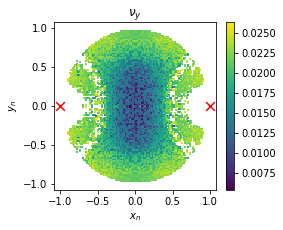

In [28]:
plt.figure(figsize=[4,3.3])
f1=plt.scatter(pData[:,0],pData[:,2],c=Py,s=1.6,marker='s')
plt.scatter(pData[:,0],-pData[:,2],c=Py,s=1.6,marker='s')
plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
plt.xlim(-0.98*1.1,0.98*1.1)
plt.ylim(-0.98*1.1,0.98*1.1)
plt.title(r'$\nu_y$')
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('Realistic.nuy_over_arc.at_turn=2049.png',dpi=180)

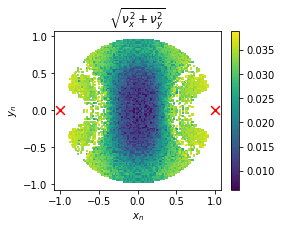

In [29]:
plt.figure(figsize=[4,3.3])
f1=plt.scatter(pData[:,0],pData[:,2],c=P,s=1.6,marker='s')
plt.scatter(pData[:,0],-pData[:,2],c=P,s=1.6,marker='s')
plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
plt.xlim(-0.98*1.1,0.98*1.1)
plt.ylim(-0.98*1.1,0.98*1.1)
plt.title(r'$\sqrt{\nu_x^2+\nu_y^2}$')
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('Realistic.nuL2_over_arc.at_turn=2049.png',dpi=180)